In [33]:
# Pipeline (first cell)

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.factors import Returns
from sklearn.linear_model import LinearRegression 
import numpy as np
    
    
def sma(n):
    return SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=n, mask=QTradableStocksUS())

def percent_change(a, b):
    return (a - b) / b

def make_training_pipeline():
    base_universe = QTradableStocksUS()
        
    stocktwits_score = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=1,)
    stocktwits_cross = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=20,)
    stocktwits_final = (stocktwits_score - stocktwits_cross).zscore()
    
    sentdex_score = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 1,)
    sentdex_cross = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 20,)
    sentdex_final = (sentdex_score - sentdex_cross).zscore()
    
    combined_score = (stocktwits_final + sentdex_final) / 2
        
    #Philip's stuff
    #yesterday's close price.
    close = USEquityPricing.close.latest
    #10 day simple moving average
    sma_10 = sma(10)
    #actual factor
    sma_10_close = -percent_change(sma_10, close).abs()


    return Pipeline(columns={
        'sentiment_score': combined_score,
        'eps_surprise': EarningsSurprises.eps_pct_diff_surp.latest,
        'sma_crossover': sma_10_close,
        'returns': Returns(window_length=180)
        })

def make_pipeline(coefs):
    base_universe = QTradableStocksUS()
        
    stocktwits_score = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=1,)
    stocktwits_cross = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=20,)
    stocktwits_final = (stocktwits_score - stocktwits_cross).zscore()
    
    sentdex_score = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 1,)
    sentdex_cross = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 20,)
    sentdex_final = (sentdex_score - sentdex_cross).zscore()
    
    combined_score = (stocktwits_final + sentdex_final) / 2
    
    #Philip's stuff
    #yesterday's close price.
    close = USEquityPricing.close.latest
    #10 day simple moving average
    sma_10 = sma(10)
    #actual factor
    sma_10_close = -percent_change(sma_10, close).abs()
    
    return Pipeline(columns={
        'score': -(coefs[0]*combined_score + coefs[1]*EarningsSurprises.eps_pct_diff_surp.latest + coefs[2]*sma_10_close).abs()
        })


my_pipe = make_training_pipeline()

pipeline_data = run_pipeline(my_pipe, start_date='2012-1-1', end_date='2014-6-1').dropna()

X_train = np.delete(pipeline_data.values, 3, 1)
Y_train = pipeline_data.values[:,3]

model = LinearRegression().fit(X_train, Y_train)
coefs = model.coef_
print(model.coef_)
# coefs[1] *= -1

my_pipe = make_pipeline(coefs)
pipeline_data_final = run_pipeline(my_pipe, start_date='2014-1-1', end_date='2016-1-1').dropna()




[  3.90190147e-06  -6.36497835e-03   8.73288426e-05]


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-24.186921,-8.579962e-02,-0.536603,1.332484,48986,20.085861
2,-0.133992,-4.130933e-02,-0.074541,0.018510,48678,19.959571
3,-0.061360,-2.056372e-02,-0.037390,0.008526,48670,19.956291
4,-0.031822,-8.274825e-03,-0.017796,0.005078,48678,19.959571
5,-0.014640,-1.801424e-10,-0.003835,0.004062,48871,20.038707


Returns Analysis


,1D,5D,10D
Ann. alpha,0.115,0.094,0.088
beta,-0.189,-0.254,-0.238
Mean Period Wise Return Top Quantile (bps),0.504,0.876,1.124
Mean Period Wise Return Bottom Quantile (bps),-2.861,-2.994,-3.316
Mean Period Wise Spread (bps),3.365,3.922,4.495


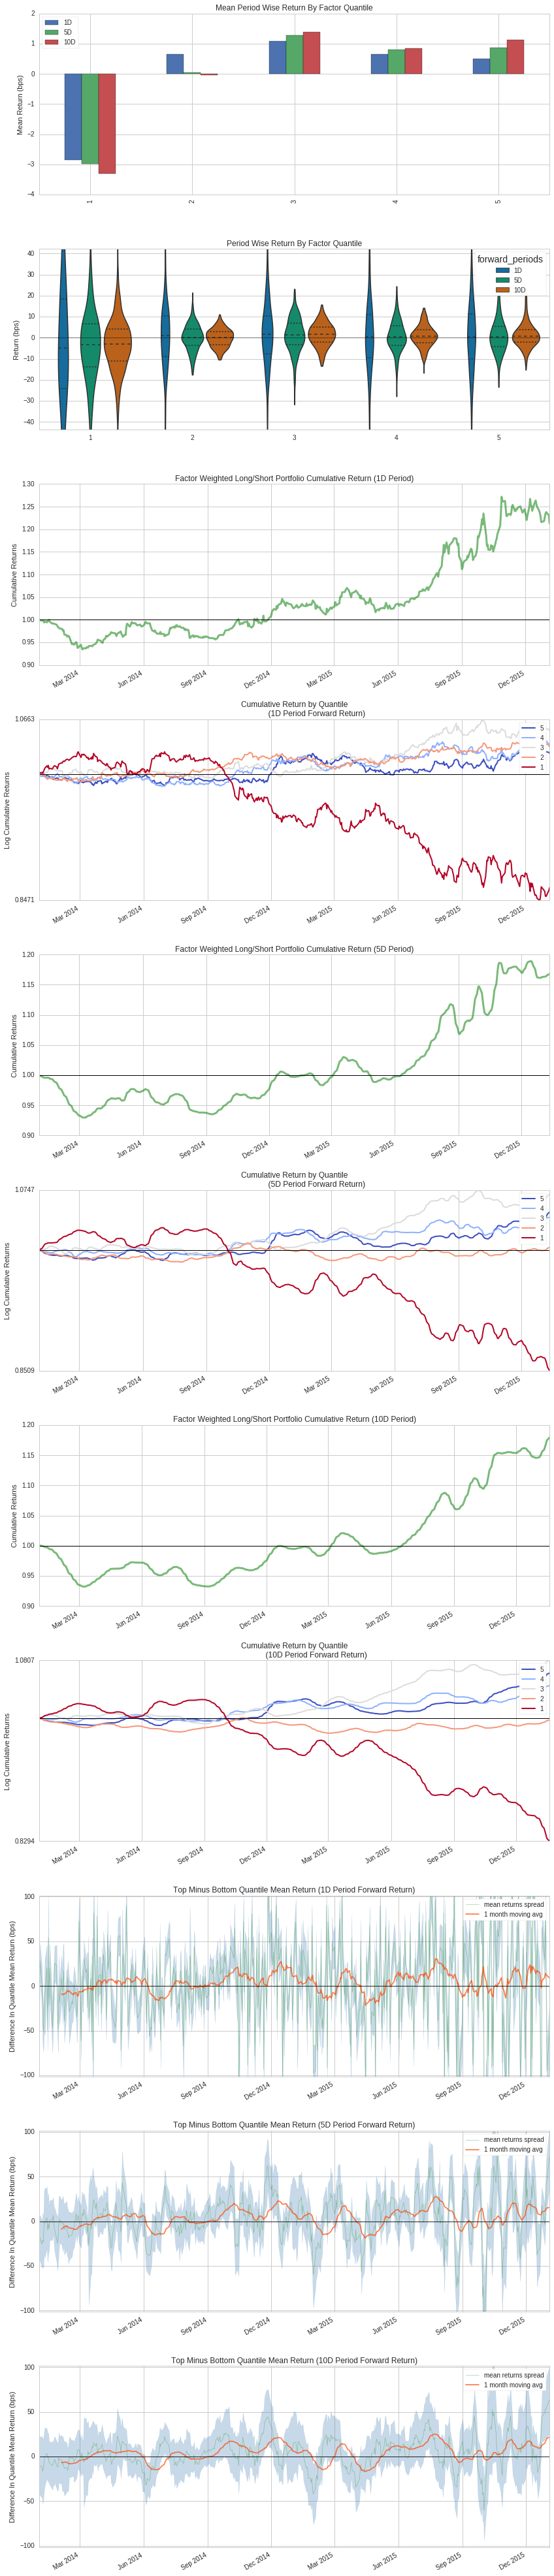

Information Analysis


,1D,5D,10D
IC Mean,0.009,0.017,0.024
IC Std.,0.088,0.091,0.090
Risk-Adjusted IC,0.097,0.183,0.265
t-stat(IC),2.186,4.112,5.961
p-value(IC),0.029,0.000,0.000
IC Skew,-0.067,-0.038,-0.070
IC Kurtosis,-0.598,-0.210,-0.118


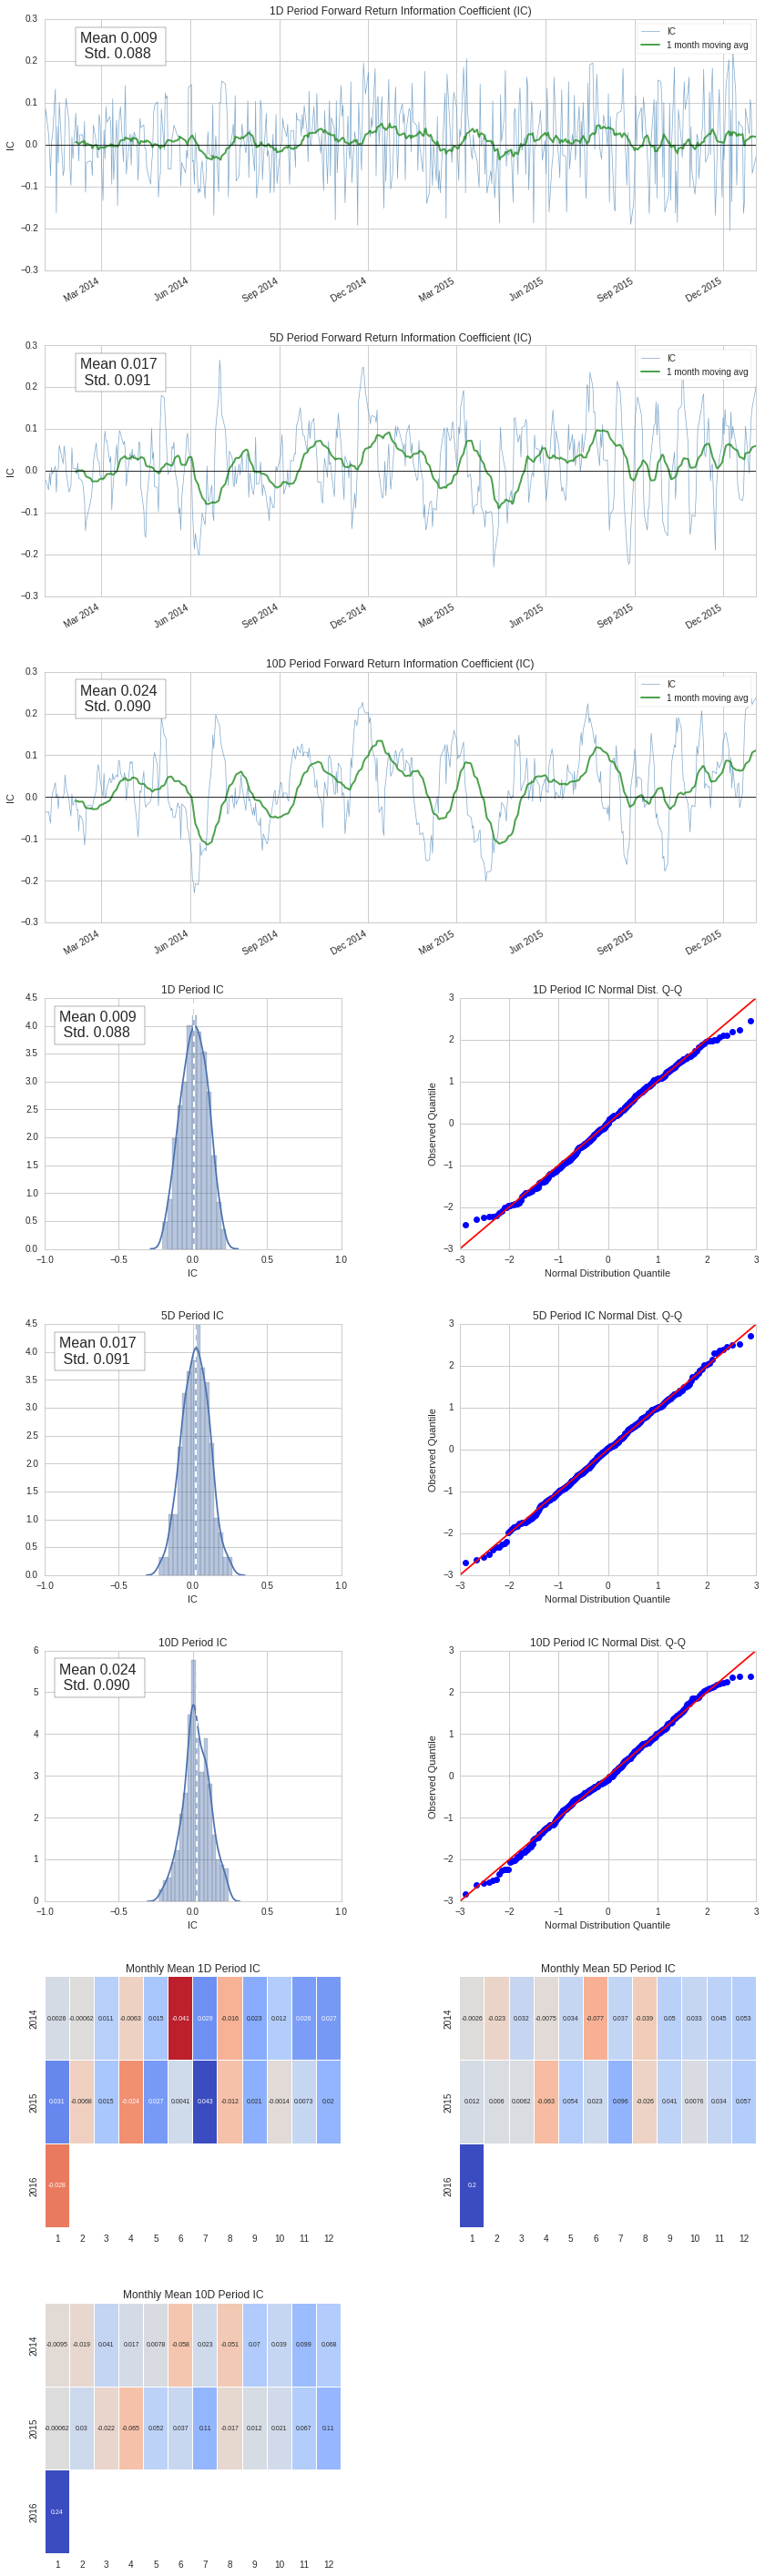

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.104,0.014,0.055
Quantile 2 Mean Turnover,0.145,0.022,0.080
Quantile 3 Mean Turnover,0.159,0.024,0.088
Quantile 4 Mean Turnover,0.153,0.023,0.085
Quantile 5 Mean Turnover,0.120,0.015,0.064


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.99,0.95,0.9


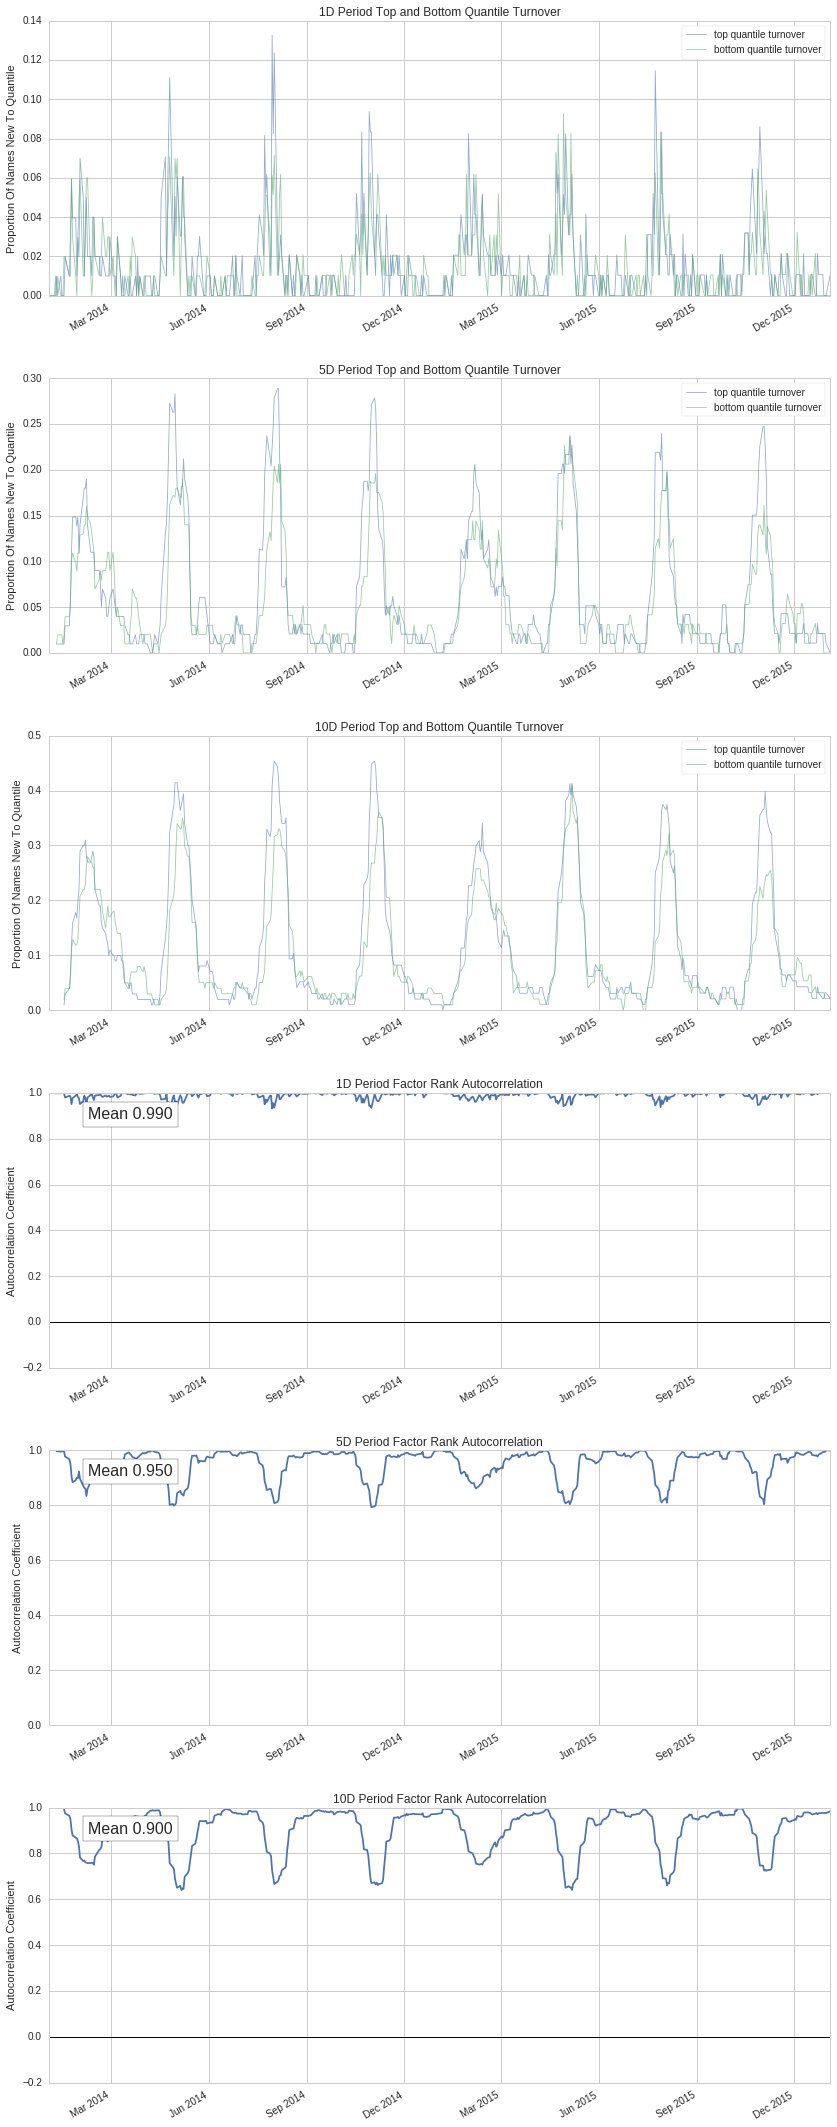

In [34]:
# Alphalens (second cell)

from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet


pricing_data = get_pricing(
  symbols=pipeline_data.index.levels[1], # Finds all assets that appear at least once in the pipeline
  start_date='2014-1-1',
  end_date='2016-2-1', #1 trading day after end date of pipeline
  fields='open_price'
)

merged_data = get_clean_factor_and_forward_returns(
  factor=pipeline_data_final['score'],
  prices=pricing_data
)

create_full_tear_sheet(merged_data)